In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
class StockDataset:
    def __init__(self, filepath, time_steps=30, val_ratio=0.2, test_ratio=0.2):
        self.filepath = filepath
        self.time_steps = time_steps
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio


        self.data = pd.read_csv(filepath)
        self.raw_seq = self.data['ClosePrice'].values.reshape(-1, 1)

        self.scaler = MinMaxScaler()
        self.normalized_seq = self.scaler.fit_transform(self.raw_seq)

        # Split dataset
        self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = self._prepare_data()
    def _create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.time_steps):
            X.append(data[i:i + self.time_steps])
            y.append(data[i + self.time_steps])
        return np.array(X), np.array(y)

    def _prepare_data(self):
        total_len = len(self.normalized_seq)
        test_size = int(total_len * self.test_ratio)
        val_size = int(total_len * self.val_ratio)

        train_data = self.normalized_seq[:-(test_size + val_size)]
        val_data = self.normalized_seq[-(test_size + val_size):-test_size]
        test_data = self.normalized_seq[-test_size:]

        X_train, y_train = self._create_sequences(train_data)
        X_val, y_val = self._create_sequences(val_data)
        X_test, y_test = self._create_sequences(test_data)

        return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
from tensorflow.keras.layers import Input
#input layer
def build_model(model_type, input_shape, rnn_size=128, dropout=0.2):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'VanillaRNN':
        model.add(SimpleRNN(rnn_size, activation='tanh'))
    elif model_type == 'LSTM':
        model.add(LSTM(rnn_size, activation='tanh'))
    elif model_type == 'GRU':
        model.add(GRU(rnn_size, activation='tanh'))
    else:
        raise ValueError("Invalid model type. Choose from 'VanillaRNN', 'LSTM', 'GRU'")
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=50):

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, save_weights_only=False)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )
    return history

In [ ]:
def evaluate_model(model, X_test, y_test, scaler):
    # predict
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)


    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")


    #  MDA
    y_test_diff = np.sign(np.diff(y_test_rescaled.flatten()))
    y_pred_diff = np.sign(np.diff(y_pred_rescaled.flatten()))
    mda = np.mean(y_test_diff == y_pred_diff)
    print(f"Test MDA: {mda:.4f}")

In [ ]:
def plot_results(history, y_test, y_pred, scaler):

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled, label='True Values')
    plt.plot(y_pred_rescaled, label='Predictions')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SH300IFcombined.csv to SH300IFcombined.csv


Epoch 1/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0055 - val_loss: 3.4808e-05 - learning_rate: 0.0010
Epoch 2/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.2168e-04 - val_loss: 4.8815e-05 - learning_rate: 0.0010
Epoch 3/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.6096e-04 - val_loss: 5.9963e-04 - learning_rate: 0.0010
Epoch 4/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.4054e-04 - val_loss: 1.6606e-05 - learning_rate: 0.0010
Epoch 5/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 9.7712e-05 - val_loss: 1.4641e-05 - learning_rate: 0.0010
Epoch 6/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7.8902e-05 - val_loss: 8.8767e-05 - learning_rate: 0.0010
Epoch 7/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 6.4822e-05 - val_loss: 3.6878e-05 - learning_rate: 5.0000e-04
Epoch 8/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 8.5354e-05 - val_loss: 2.4038e-05 - learning_rate: 5.0000e-04
Epoch 9/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step 

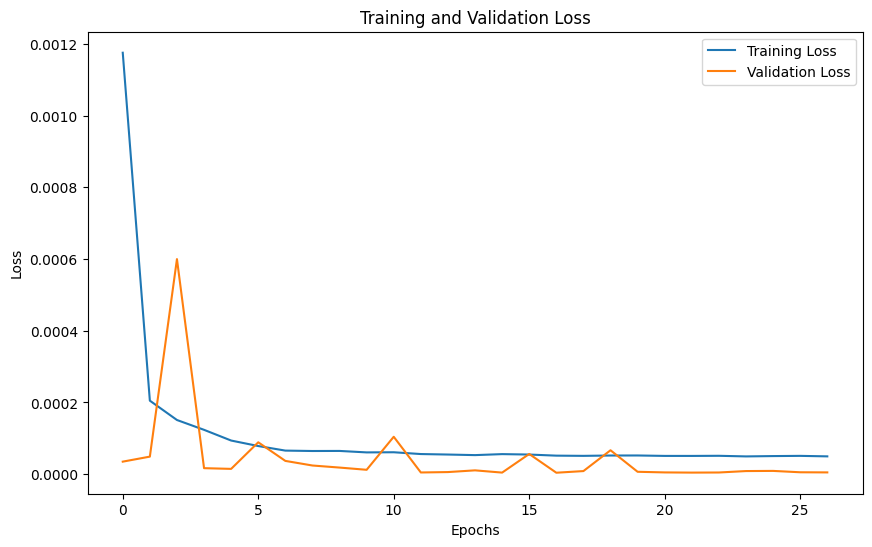

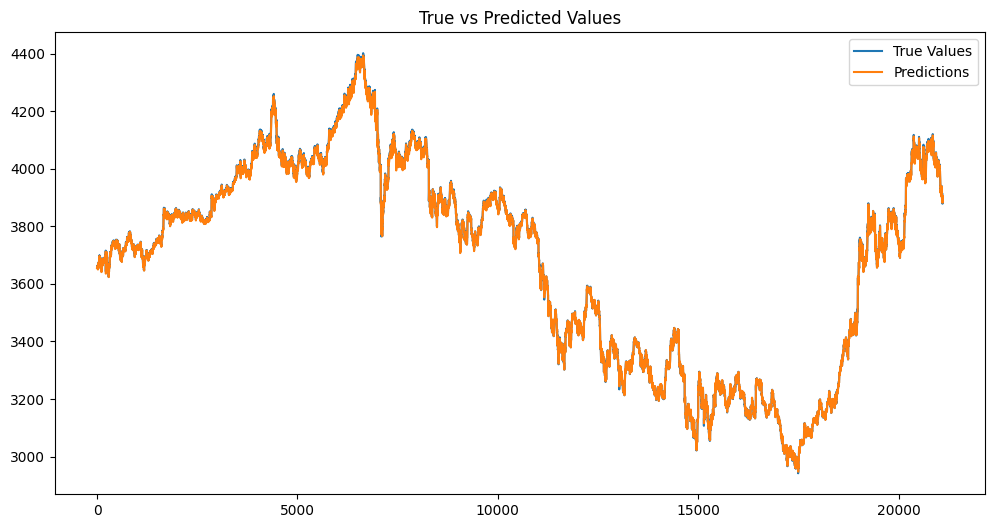

In [ ]:
if __name__ == "__main__":

    filepath = "SH300IFcombined.csv"
    model_type = "VanillaRNN"


    dataset = StockDataset(filepath, time_steps=30)


    input_shape = (dataset.X_train.shape[1], dataset.X_train.shape[2])
    model = build_model(model_type, input_shape)


    history = train_model(model, dataset.X_train, dataset.y_train, dataset.X_val, dataset.y_val)


    evaluate_model(model, dataset.X_test, dataset.y_test, dataset.scaler)


    plot_results(history, dataset.y_test, model.predict(dataset.X_test), dataset.scaler)

Epoch 1/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0023 - val_loss: 3.9145e-05 - learning_rate: 0.0010
Epoch 2/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.7260e-04 - val_loss: 5.7233e-05 - learning_rate: 0.0010
Epoch 3/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.2925e-04 - val_loss: 7.5826e-04 - learning_rate: 0.0010
Epoch 4/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.5266e-04 - val_loss: 2.0438e-05 - learning_rate: 0.0010
Epoch 5/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.3561e-05 - val_loss: 7.4392e-06 - learning_rate: 0.0010
Epoch 6/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.8801e-05 - val_loss: 5.3629e-05 - learning_rate: 0.0010
Epoch 7/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.4127e-05 - val_loss: 7.4399e-06 - learning_rate: 5.0000e-04
Epoch 8/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.2893e-05 - val_loss: 2.7020e-05 - learning_rate: 5.0000e-04
Epoch 9/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step 

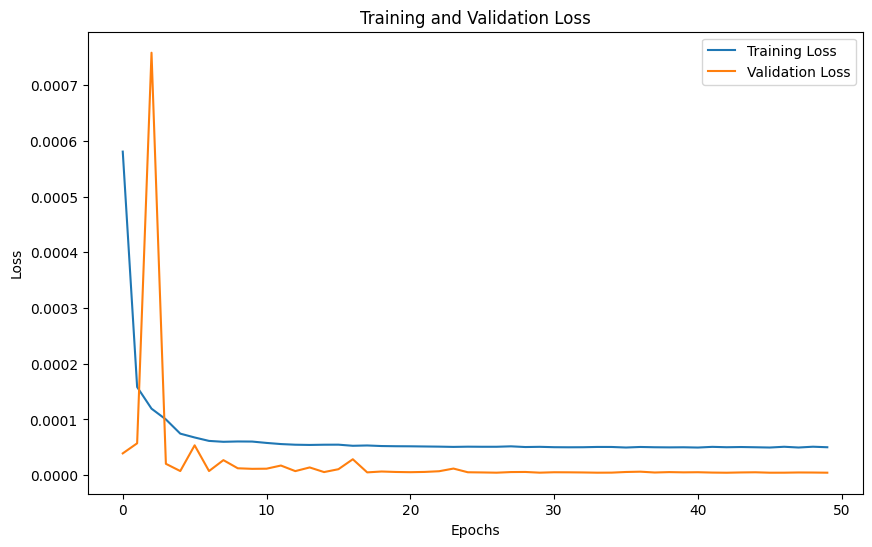

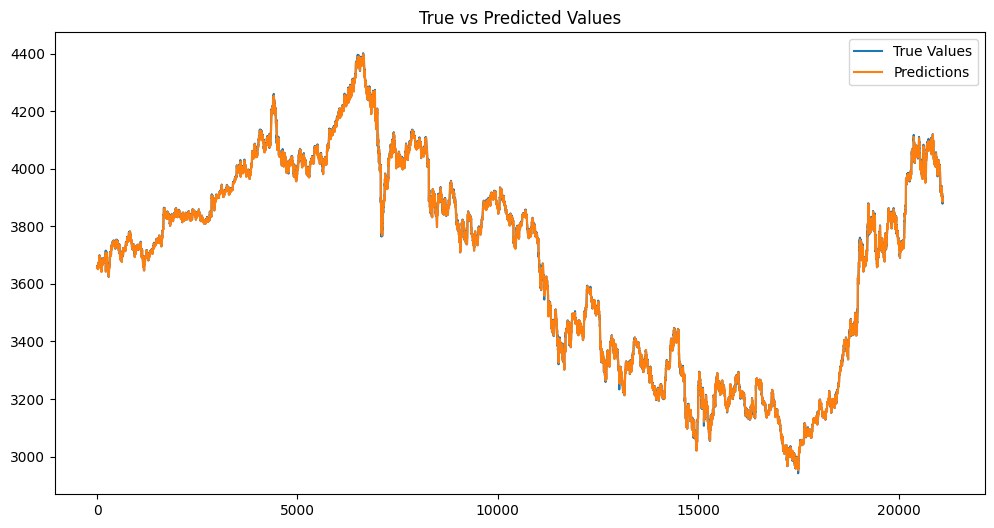

In [ ]:
if __name__ == "__main__":

    filepath = "SH300IFcombined.csv"
    model_type = "LSTM"


    dataset = StockDataset(filepath, time_steps=30)

    input_shape = (dataset.X_train.shape[1], dataset.X_train.shape[2])
    model = build_model(model_type, input_shape)


    history = train_model(model, dataset.X_train, dataset.y_train, dataset.X_val, dataset.y_val)


    evaluate_model(model, dataset.X_test, dataset.y_test, dataset.scaler)

    plot_results(history, dataset.y_test, model.predict(dataset.X_test), dataset.scaler)

Epoch 1/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0022 - val_loss: 4.9782e-05 - learning_rate: 0.0010
Epoch 2/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.5331e-04 - val_loss: 1.6768e-05 - learning_rate: 0.0010
Epoch 3/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.1988e-04 - val_loss: 3.7596e-05 - learning_rate: 0.0010
Epoch 4/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.6968e-05 - val_loss: 7.3425e-05 - learning_rate: 0.0010
Epoch 5/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.7956e-05 - val_loss: 9.2341e-06 - learning_rate: 0.0010
Epoch 6/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.5391e-05 - val_loss: 2.7286e-05 - learning_rate: 0.0010
Epoch 7/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.5302e-05 - val_loss: 1.9690e-05 - learning_rate: 5.0000e-04
Epoch 8/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.5693e-05 - val_loss: 2.7859e-05 - learning_rate: 5.0000e-04
Epoch 9/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step 

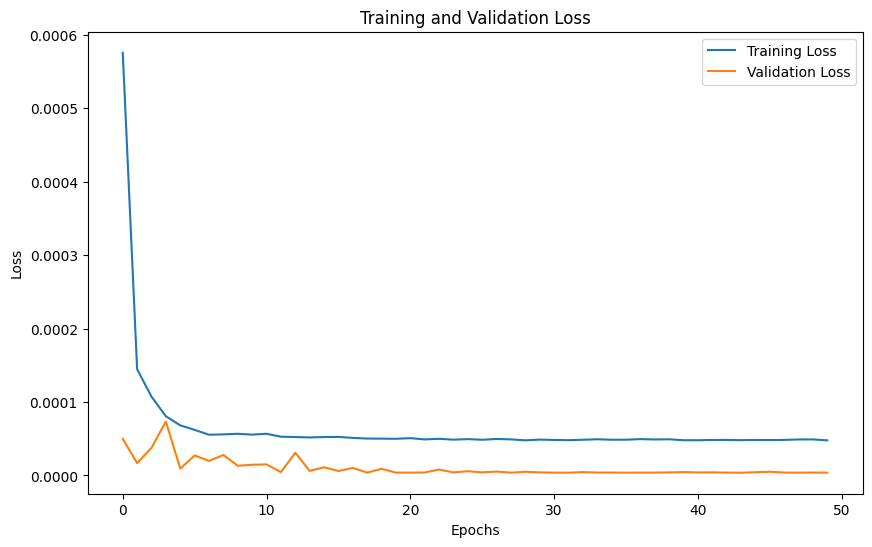

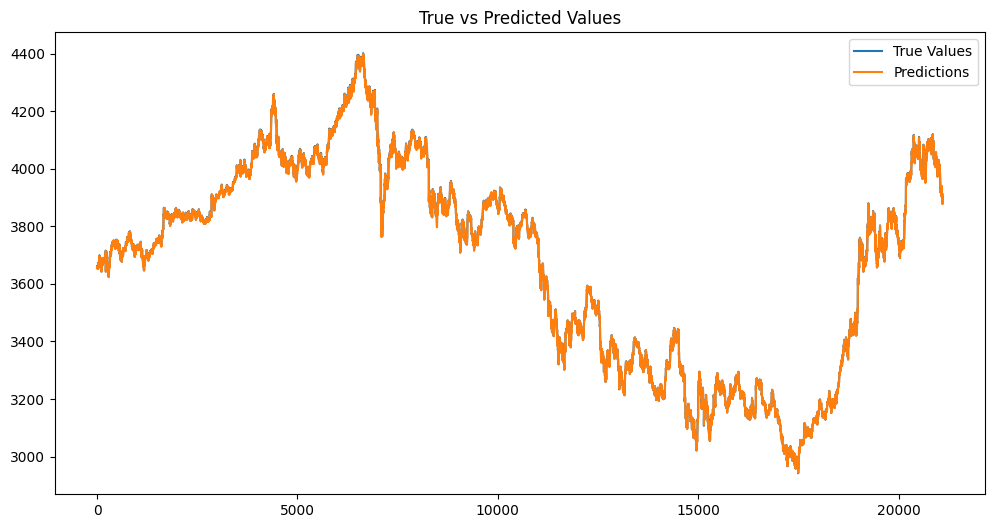

In [ ]:
if __name__ == "__main__":

    filepath = "SH300IFcombined.csv"
    model_type = "GRU"


    dataset = StockDataset(filepath, time_steps=30)


    input_shape = (dataset.X_train.shape[1], dataset.X_train.shape[2])
    model = build_model(model_type, input_shape)


    history = train_model(model, dataset.X_train, dataset.y_train, dataset.X_val, dataset.y_val)


    evaluate_model(model, dataset.X_test, dataset.y_test, dataset.scaler)


    plot_results(history, dataset.y_test, model.predict(dataset.X_test), dataset.scaler)

In [ ]:
from itertools import product


param_grid = {
    "rnn_size": [64, 128],
    "time_steps": [30, 50],
    "dropout": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [64, 128]
}


param_combinations = list(product(
    param_grid["rnn_size"],
    param_grid["time_steps"],
    param_grid["dropout"],
    param_grid["learning_rate"],
    param_grid["batch_size"]
))

In [ ]:
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

def train_and_evaluate(params, dataset):

    rnn_size, time_steps, dropout, learning_rate, batch_size = params

    dataset.time_steps = time_steps
    dataset.X_train, dataset.y_train, dataset.X_val, dataset.y_val, dataset.X_test, dataset.y_test = dataset._prepare_data()

    model = Sequential()
    model.add(Input(shape=(dataset.X_train.shape[1], dataset.X_train.shape[2])))
    model.add(GRU(rnn_size, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(1))


    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')


    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        dataset.X_train, dataset.y_train,
        validation_data=(dataset.X_val, dataset.y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )


    val_loss = min(history.history['val_loss'])
    return val_loss, model

In [ ]:
best_params = None
best_val_loss = float('inf')
best_model = None

for params in param_combinations:
    print(f"Training with params: {params}")
    val_loss, model = train_and_evaluate(params, dataset)
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_model = model

print(f"Best Params: {best_params}")
print(f"Best Validation Loss: {best_val_loss}")

Training with params: (64, 30, 0.2, 0.001, 64)
Validation Loss: 4.513554358709371e-06
Training with params: (64, 30, 0.2, 0.001, 128)
Validation Loss: 5.2203176892362535e-06
Training with params: (64, 30, 0.2, 0.0005, 64)
Validation Loss: 5.128541033627698e-06
Training with params: (64, 30, 0.2, 0.0005, 128)
Validation Loss: 5.4753922995587345e-06
Training with params: (64, 30, 0.3, 0.001, 64)
Validation Loss: 4.899809482594719e-06
Training with params: (64, 30, 0.3, 0.001, 128)
Validation Loss: 1.0548923455644399e-05
Training with params: (64, 30, 0.3, 0.0005, 64)
Validation Loss: 4.415679541125428e-06
Training with params: (64, 30, 0.3, 0.0005, 128)
Validation Loss: 6.416158157662721e-06
Training with params: (64, 50, 0.2, 0.001, 64)
Validation Loss: 6.737868261552649e-06
Training with params: (64, 50, 0.2, 0.001, 128)
Validation Loss: 4.286300736566773e-06
Training with params: (64, 50, 0.2, 0.0005, 64)
Validation Loss: 4.322432687331457e-06
Training with params: (64, 50, 0.2, 0.000

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


results = []


for params in param_combinations:
    print(f"Training with params: {params}")
    val_loss, _ = train_and_evaluate(params, dataset)
    print(f"Validation Loss: {val_loss}")

    results.append({"rnn_size": params[0],
                    "time_steps": params[1],
                    "dropout": params[2],
                    "learning_rate": params[3],
                    "batch_size": params[4],
                    "val_loss": val_loss})


results_df = pd.DataFrame(results)
print(results_df)

Training with params: (64, 30, 0.2, 0.001, 64)
Validation Loss: 6.9868551690888125e-06
Training with params: (64, 30, 0.2, 0.001, 128)
Validation Loss: 5.325770416675368e-06
Training with params: (64, 30, 0.2, 0.0005, 64)
Validation Loss: 6.158648830023594e-06
Training with params: (64, 30, 0.2, 0.0005, 128)
Validation Loss: 9.768933523446321e-06
Training with params: (64, 30, 0.3, 0.001, 64)
Validation Loss: 7.595402621518588e-06
Training with params: (64, 30, 0.3, 0.001, 128)
Validation Loss: 1.0524897334107663e-05
Training with params: (64, 30, 0.3, 0.0005, 64)
Validation Loss: 9.65383787843166e-06
Training with params: (64, 30, 0.3, 0.0005, 128)
Validation Loss: 5.14178236699081e-06
Training with params: (64, 50, 0.2, 0.001, 64)
Validation Loss: 3.99051441490883e-06
Training with params: (64, 50, 0.2, 0.001, 128)
Validation Loss: 3.965416453866055e-06
Training with params: (64, 50, 0.2, 0.0005, 64)
Validation Loss: 3.76313414562901e-06
Training with params: (64, 50, 0.2, 0.0005, 12

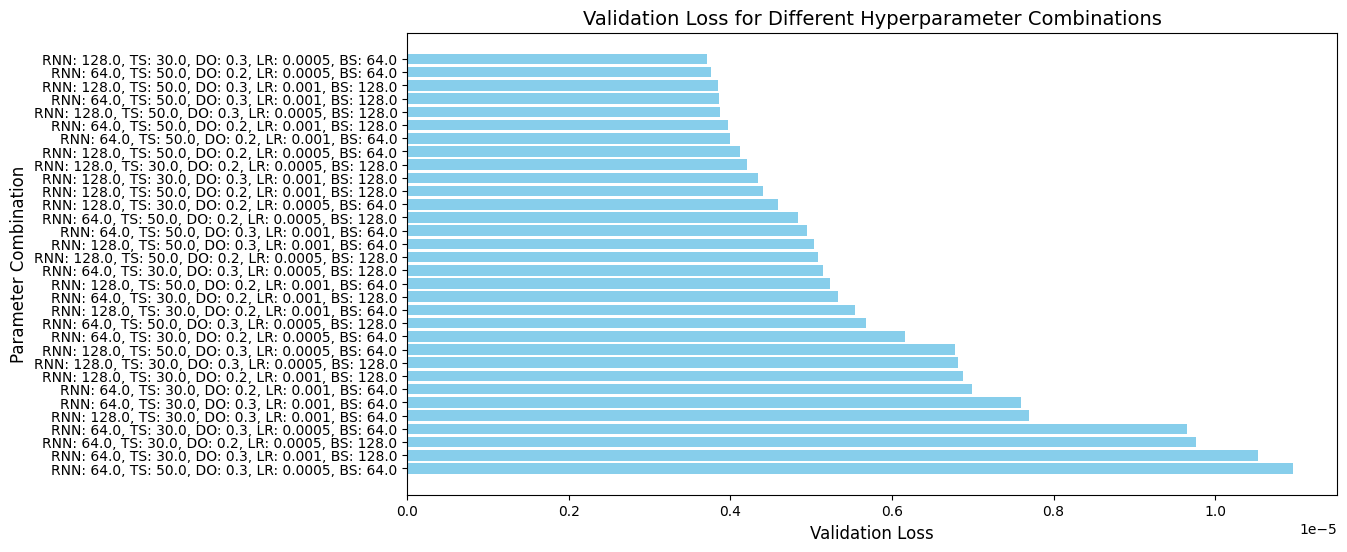

In [ ]:

sorted_results = results_df.sort_values(by="val_loss", ascending=True)


plt.figure(figsize=(12, 6))
plt.barh(
    [f"RNN: {row.rnn_size}, TS: {row.time_steps}, DO: {row.dropout}, LR: {row.learning_rate}, BS: {row.batch_size}"
     for _, row in sorted_results.iterrows()],
    sorted_results["val_loss"],
    color='skyblue'
)
plt.xlabel("Validation Loss", fontsize=12)
plt.ylabel("Parameter Combination", fontsize=12)
plt.title("Validation Loss for Different Hyperparameter Combinations", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

In [ ]:

def train_and_evaluate(params, dataset):

    rnn_size, time_steps, dropout, learning_rate, batch_size = params


    dataset.time_steps = time_steps
    dataset.X_train, dataset.y_train, dataset.X_val, dataset.y_val, dataset.X_test, dataset.y_test = dataset._prepare_data()


    model = Sequential()
    model.add(Input(shape=(dataset.X_train.shape[1], dataset.X_train.shape[2])))  # 输入层
    model.add(GRU(rnn_size, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(1))


    optimizer = optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')


    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = model.fit(
        dataset.X_train, dataset.y_train,
        validation_data=(dataset.X_val, dataset.y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )


    val_loss = min(history.history['val_loss'])
    return val_loss, model

In [ ]:

results = []


for params in param_combinations:
    print(f"Training with params: {params}")
    val_loss, _ = train_and_evaluate(params, dataset)
    print(f"Validation Loss: {val_loss}")
    results.append({"rnn_size": params[0],
                    "time_steps": params[1],
                    "dropout": params[2],
                    "learning_rate": params[3],
                    "batch_size": params[4],
                    "val_loss": val_loss})


results_df = pd.DataFrame(results)
print(results_df)

Training with params: (64, 30, 0.2, 0.001, 64)
Validation Loss: 1.7398882846464403e-05
Training with params: (64, 30, 0.2, 0.001, 128)
Validation Loss: 6.87806386849843e-05
Training with params: (64, 30, 0.2, 0.0005, 64)
Validation Loss: 3.981478221248835e-05
Training with params: (64, 30, 0.2, 0.0005, 128)
Validation Loss: 0.0012884686002507806
Training with params: (64, 30, 0.3, 0.001, 64)
Validation Loss: 2.780014619929716e-05
Training with params: (64, 30, 0.3, 0.001, 128)
Validation Loss: 0.00017161406867671758
Training with params: (64, 30, 0.3, 0.0005, 64)
Validation Loss: 5.64781112188939e-05
Training with params: (64, 30, 0.3, 0.0005, 128)
Validation Loss: 0.0013061147183179855
Training with params: (64, 50, 0.2, 0.001, 64)
Validation Loss: 1.684819653746672e-05
Training with params: (64, 50, 0.2, 0.001, 128)
Validation Loss: 6.828887126175687e-05
Training with params: (64, 50, 0.2, 0.0005, 64)
Validation Loss: 0.00012003686424577609
Training with params: (64, 50, 0.2, 0.0005,

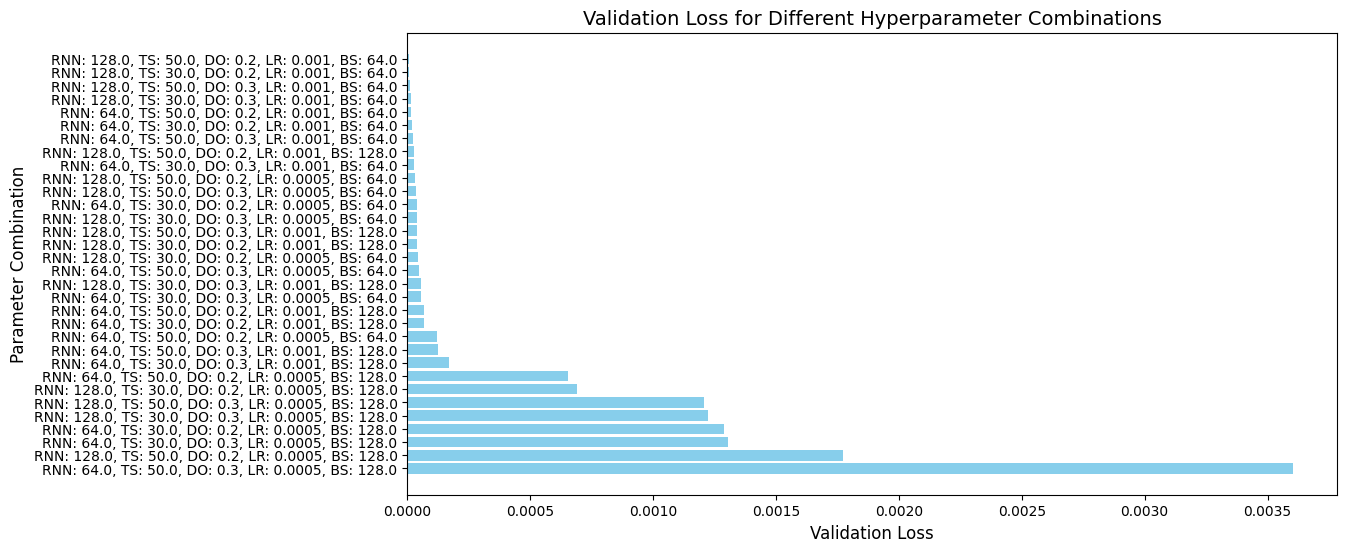

In [ ]:

sorted_results = results_df.sort_values(by="val_loss", ascending=True)


plt.figure(figsize=(12, 6))
plt.barh(
    [f"RNN: {row.rnn_size}, TS: {row.time_steps}, DO: {row.dropout}, LR: {row.learning_rate}, BS: {row.batch_size}"
     for _, row in sorted_results.iterrows()],
    sorted_results["val_loss"],
    color='skyblue'
)
plt.xlabel("Validation Loss", fontsize=12)
plt.ylabel("Parameter Combination", fontsize=12)
plt.title("Validation Loss for Different Hyperparameter Combinations", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_gru_model(input_shape, rnn_size=128, dropout=0.2, learning_rate=0.001):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(rnn_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))


    optimizer = tanh(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:

input_shape = (dataset.X_train.shape[1], dataset.X_train.shape[2])  # 输入形状
model = build_gru_model(input_shape, rnn_size=128, dropout=0.2, learning_rate=0.001)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    dataset.X_train, dataset.y_train,
    validation_data=(dataset.X_val, dataset.y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)


model.summary()

Epoch 1/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0051 - val_loss: 3.5625e-05
Epoch 2/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 3.7017e-04 - val_loss: 2.0758e-05
Epoch 3/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.6854e-04 - val_loss: 1.4322e-05
Epoch 4/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.3210e-04 - val_loss: 2.0172e-05
Epoch 5/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.1664e-04 - val_loss: 1.8854e-05
Epoch 6/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.0988e-04 - val_loss: 5.6173e-05
Epoch 7/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.1096e-04 - val_loss: 2.3680e-05
Epoch 8/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.0558e-04 - val_loss: 1.2356e-05
Epoch 9/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 2.0670e-04 - val_loss: 5.3702e-05
Epoch 10/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.0294e-04 - val_loss: 1.3651e-05
Epoch 11/50
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_101 (GRU)                        │ (None, 128)                 │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_106 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,301 (591.02 KB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 100,868 (394.02 KB)

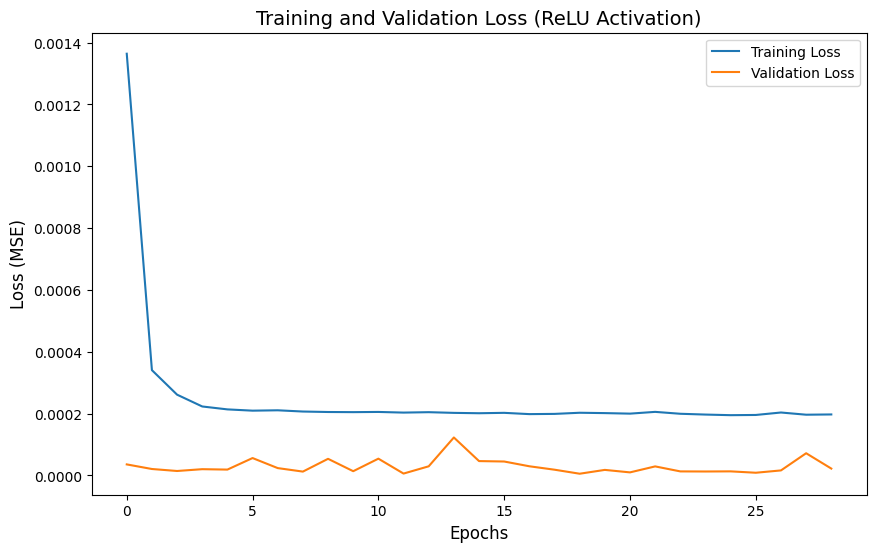

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss (ReLU Activation)', fontsize=14)
plt.legend()
plt.show()